# Recommender Systems with Python

Welcome to the code notebook for Recommender Systems with Python. In this lecture we will develop basic recommendation systems using Python and pandas. There is another notebook: *Advanced Recommender Systems with Python*. That notebook goes into more detail with the same data set.

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead you have the option to work through the advanced lecture version of this notebook (totally optional!).

Let's get started!

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

## Get the Data

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Now let's get the movie titles:

In [4]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge them together:

In [5]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [44]:
avg_ratings = df.groupby('title')['rating'].mean()
avg_ratings.sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [45]:
ratings_count = df.groupby('title')['rating'].count()
ratings_count.sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [46]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [47]:
ratings = avg_ratings.to_frame()

In [48]:
avg_ratings

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [49]:
ratings

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390
...,...
Young Guns II (1990),2.772727
"Young Poisoner's Handbook, The (1995)",3.341463
Zeus and Roxanne (1997),2.166667


In [50]:
ratings_count = ratings_count.to_frame()

In [51]:
ratings_count

,rating
title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41
...,...
Young Guns II (1990),44
"Young Poisoner's Handbook, The (1995)",41
Zeus and Roxanne (1997),6


Now set the number of ratings column:

In [53]:
ratings['num of ratings'] = ratings_count
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now a few histograms:

<AxesSubplot:>

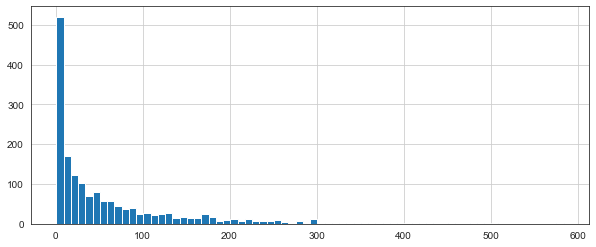

In [54]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

Text(0, 0.5, 'no. movies')

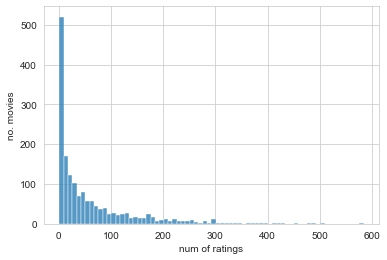

In [61]:
sns.set_style('whitegrid')
sns.histplot(ratings['num of ratings'], bins=70)
plt.ylabel('no. movies')

<AxesSubplot:>

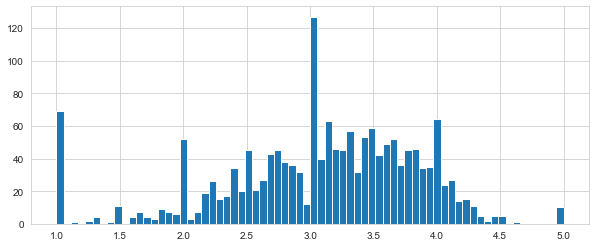

In [62]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

<AxesSubplot:xlabel='rating', ylabel='Count'>

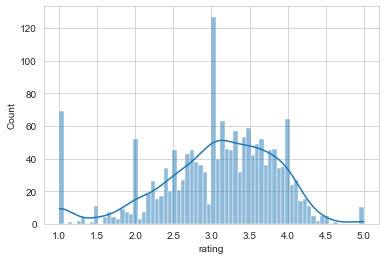

In [63]:
sns.histplot(ratings['rating'], bins=70, kde=True)

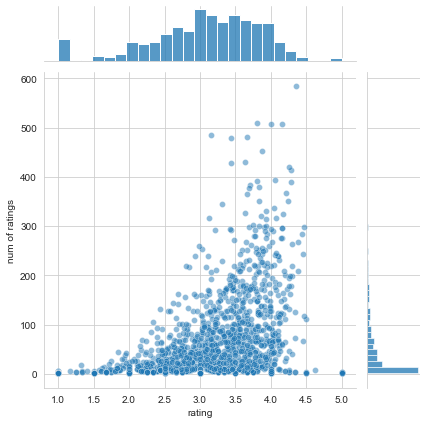

In [64]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [168]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
moviemat.sum(axis=1).sort_values()

user_id
0        11.0
685      41.0
302      49.0
824      52.0
866      54.0
        ...  
276    1788.0
416    1874.0
13     1958.5
655    1969.0
450    2079.0
Length: 944, dtype: float64

In [174]:
moviemat.sum(axis=0).sort_values()

title
Low Life, The (1994)                                    1.0
I, Worst of All (Yo, la peor de todas) (1990)           1.0
Police Story 4: Project S (Chao ji ji hua) (1993)       1.0
To Cross the Rubicon (1991)                             1.0
Tigrero: A Film That Was Never Made (1994)              1.0
                                                      ...  
Raiders of the Lost Ark (1981)                       1786.0
Contact (1997)                                       1936.0
Return of the Jedi (1983)                            2032.0
Fargo (1996)                                         2111.0
Star Wars (1977)                                     2546.0
Length: 1664, dtype: float64

Most rated movie:

In [67]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Highest rated movies:

In [70]:
ratings.sort_values('rating', ascending=False). head(10)

,rating,num of ratings
title,,
They Made Me a Criminal (1939),5.0,1
Marlene Dietrich: Shadow and Light (1996),5.0,1
"Saint of Fort Washington, The (1993)",5.0,2
Someone Else's America (1995),5.0,1
Star Kid (1997),5.0,3
"Great Day in Harlem, A (1994)",5.0,1
Aiqing wansui (1994),5.0,1
Santa with Muscles (1996),5.0,2
Prefontaine (1997),5.0,3


Highest rating movies with more than 100 reviews:

In [78]:
ratings[ratings['num of ratings'] > 100].sort_values('rating', ascending=False).head(10)

,rating,num of ratings
title,,
"Close Shave, A (1995)",4.491071,112
Schindler's List (1993),4.466443,298
"Wrong Trousers, The (1993)",4.466102,118
Casablanca (1942),4.456790,243
"Shawshank Redemption, The (1994)",4.445230,283
Rear Window (1954),4.387560,209
"Usual Suspects, The (1995)",4.385768,267
Star Wars (1977),4.359589,584
12 Angry Men (1957),4.344000,125


Hmmm...at what no. ratings should be the cutoff?
How many movies are left after a certain cutoff?
How many reviews are left after a certain cutoff?

Text(0, 0.5, 'Count of movies')

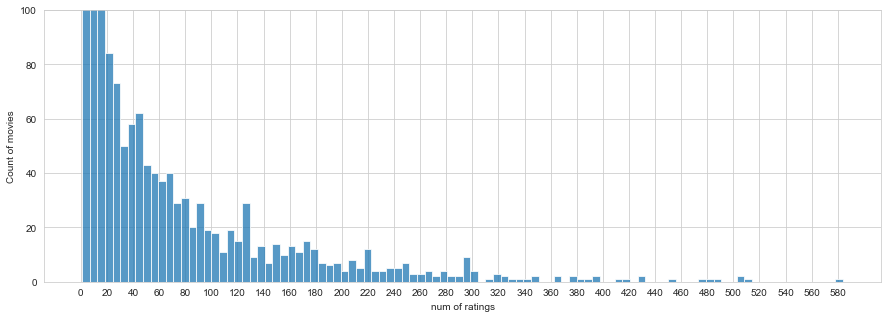

In [93]:
plt.figure(figsize=(15,5))
sns.histplot(ratings['num of ratings'],bins=100)
plt.xticks(np.arange(0, 600, 20))
plt.ylim(0,100)
plt.ylabel('Count of movies')

In [164]:
ratings[ratings['num of ratings'] > 10].sum()

rating             3656.918208
num of ratings    97635.000000
dtype: float64

In [165]:
left_no_ratings = []
for i in range(0,500):
    left_no_ratings.append(ratings[ratings['num of ratings'] > i]['num of ratings'].sum())

In [166]:
left_no_ratings[:5]

[100003, 99869, 99735, 99561, 99309]

(0.0, 70.0)

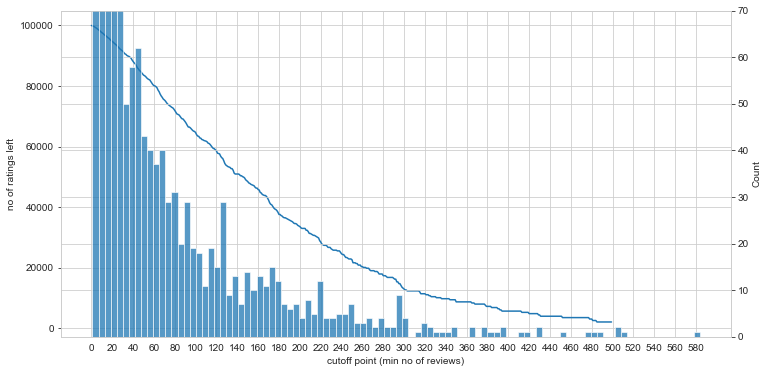

In [167]:
plt.figure(figsize=(12,6))
sns.lineplot(y=left_no_ratings, x=range(0,500))
plt.ylabel('no of ratings left')
plt.xlabel('cutoff point (min no of reviews)')
plt.xticks(np.arange(0, 600, 20))
ax = plt.gca()
ax2 = ax.twinx()
sns.histplot(ratings['num of ratings'],bins=100, ax=ax2)
#zoom
plt.ylim(0,70)

Concluding a cutoff at min 100 reviews willdrastically reduce number of movies but it will only slightly reduce the number of total reviews. The smallest cutoff to reduce the highest amount of movies would seem to be around 60.

Better way of calculating would be to see a graph of a tangent to a function (derivative) of 'no movies left vs cutoff'. Observe around what cutoff whould it 'flatten' ,where it would break i.e. where its gradient would drop to sub 1 values (decimal).


Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [126]:
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's grab the user ratings for those two movies:

In [127]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [130]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [132]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [138]:
corr_starwars = similar_to_starwars.to_frame('Correlation')
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

#note
Corr reflects average of all users similarity between rating star wars and x movie
hight corr  mean more ppl agree on rating for strar wars and x movie

In [140]:
corr_starwars.sort_values('Correlation',ascending=False).head()

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [141]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now sort the values and notice how the titles make a lot more sense:

In [151]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


Based on experimentation with cutoff value I would name it 'niche factor'. The lower it is the more obscure movies it recommends. Not necassarily less similar. The likelihood that they are similar drops but it heightens the chance of finding a similar yet under-watched movie.

Now the same for the comedy Liar Liar:

In [158]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>60].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman & Robin (1997),0.532858,62
Batman Forever (1995),0.516968,114
Bean (1997),0.504689,91
Dumb & Dumber (1994),0.494006,69
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164


# Great Job!